<h1> CMBI Coursework 1
<h3> Giuliano Costa

In [424]:
# Import the necessary libraries
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from scipy.io import loadmat
from scipy.optimize import minimize

In [425]:
"""PLOTTING"""
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_style("whitegrid", {'axes.grid' : False})


In [426]:
"""Reusable Plotly method for model fitting scatter plot"""
def plot_model_fit(measured, predicted, model_name="Model", marker_size=4, yaxis_title='Signal'):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=list(range(len(measured))),y=measured,mode='markers',name='Measured',
            marker=dict(
                size=marker_size,
                color='blue',
                opacity=0.6
            ))
    )
    fig.add_trace(
        go.Scatter(
            x=list(range(len(predicted))),y=predicted,mode='markers',name='Predicted',
            marker=dict(
                size=marker_size,
                color='red',
                opacity=0.6
            ))
    )
    fig.update_layout(
        title=model_name,xaxis_title='Measurement number',yaxis_title=yaxis_title,showlegend=True,template='seaborn',
        width=1000,
        height=600
    )
    fig.update_yaxes(showgrid=True, gridwidth=1)

    fig.show()

$\text{\large{Load Data}}$

In [427]:
"""LOAD DWI scans"""
dwis = loadmat('data_p1/data.mat')['dwis']
dwis = np.double(dwis)
dwis = dwis.transpose((3, 0, 1, 2))
[Dc, Dx, Dy, Dz] = dwis.shape
print(dwis.shape)

"""LOAD gradient directions"""
qhat = np.loadtxt("data_p1/bvecs", delimiter = " ").T
bvals = 1000 * np.sum(qhat * qhat, axis=1)
print(qhat.shape, bvals.shape)

(108, 145, 174, 145)
(108, 3) (108,)


# Q1.1

<h3> DWIS data:</h3>
108 Image volumes: 18 with b=0 attenuation, 90 diffusion weighted. All 108 measurements have been made with a different diffusion direction, but from ONE session and ONE patient. So essentially we have 108 complete brain scan volumes from top to bottom.

Each volume is made up of 145 slices. Each slice is a 145x174 pixel IMAGE.
108x145x173x145

145: X dimension of the slice

174: Y dimension of the slice

145: Z Dimension of the slice; z-depth, i.e the number of slices in each volume.

<h3>qhat & bvecs </h3>

This is the actual gradient direction information and diffusion weighting for each of the 108 recordings. The first 18 (our baseline) are naturally directionless. The other 90 have gradient directions in bvals, and qhat has the directions.


$\Large{Q.1.1.1 }$

$\text{\large{Linear diffusion tensor estimation}}$

Must solve $A=Yx$

Where $\bold{A}$ is vector of log measurements <br>
Where $Y$ is design matrix <br>
$x$ is a vector of unknown parameters (this contains the estimated signal with no attenuation and the Diffusion Tensor)

$\text{Estimate the diffusion tensor for just one voxel first.}
\\\text{ That is, take the 108 gradient directions, the one signal value, the one diffusion weight, and estimate the D tensor.}$

In [ ]:
"""CREATE Design Matrix Y"""

def create_design_matrix(bvals, qhat):
    n_meas = len(bvals)
    
    if qhat.shape[1] != n_meas:
        qhat = qhat.T
    
    # Create design matrix Y
    Y = np.zeros((n_meas, 7))
    Y[:,0] = 1  # First column is 1 for log(S0)
    
    for i in range(n_meas):
        b = bvals[i]
        q = qhat[:,i]  # Get the i-th gradient direction
        qx, qy, qz = q[0], q[1], q[2]
        
        Y[i,1] = -b * qx * qx
        Y[i,2] = -2 * b * qx * qy
        Y[i,3] = -2 * b * qx * qz
        Y[i,4] = -b * qy * qy
        Y[i,5] = -2 * b * qy * qz
        Y[i,6] = -b * qz * qz
    
    return Y


"""Linear Least Squares to Solve for """
def fit_diffusion_tensor(signals, bvals, qhat):
    log_signals = np.log(signals)
    
    Y = create_design_matrix(bvals, qhat)
    
    # Solve
    x = np.linalg.lstsq(Y, log_signals, rcond=None)[0]
    D = np.array([[x[1], x[2], x[3]],
                  [x[2], x[4], x[5]],
                  [x[3], x[5], x[6]]])
    
    return x[0], D 

def calculate_MD_FA(D):
    eigenvals = np.linalg.eigvals(D)
    MD = np.mean(eigenvals)
    num = np.sqrt(np.sum((eigenvals - MD)**2))
    den = np.sqrt(np.sum(eigenvals**2))
    FA = np.sqrt(3/2) * num/den if den != 0 else 0
    
    return MD, FA


In [429]:
avox = dwis[:, 91, 64, 71]
estimated_x, estimated_d = fit_diffusion_tensor(avox, bvals, qhat)
print("Estimated Signal with no diffusion weighting:", estimated_x)
print("Estimated Diffusion Tensor: \n", estimated_d)

Estimated Signal with no diffusion weighting: 8.355023507046369
Estimated Diffusion Tensor: 
 [[ 0.00094059  0.00013924 -0.00017357]
 [ 0.00013924  0.00065405 -0.00026257]
 [-0.00017357 -0.00026257  0.00077634]]


<h3>Now repeat the process for the whole slice

In [217]:
def create_parameter_maps(dwis, bvals, qhat, slice_idx):
    Dx, Dy = dwis.shape[1:3]
    MD_map = np.zeros((Dx, Dy))
    FA_map = np.zeros((Dx, Dy))
    
    for i in range(Dx):
        for j in range(Dy):
            # Get signals for this voxel
            signals = dwis[:,i,j,slice_idx]
            
            # Only process voxels with valid signals
            if np.all(signals > 0):
                # Fit tensor
                log_S0, D = fit_diffusion_tensor(signals, bvals, qhat)
                
                # Calculate and store parameters
                MD, FA = calculate_MD_FA(D)
                MD_map[i,j] = MD
                FA_map[i,j] = FA
    
    return MD_map, FA_map, D

def create_RGB_map(dwis, bvals, qhat, slice_idx):
    Dx, Dy = dwis.shape[1:3]
    RGB_map = np.zeros((Dx, Dy, 3))
    
    for i in range(Dx):
        for j in range(Dy):
            signals = dwis[:,i,j,slice_idx]
            if np.all(signals > 0):
                log_S0, D = fit_diffusion_tensor(signals, bvals, qhat)
                
                # Get principal eigenvector
                eigenvals, eigenvecs = np.linalg.eigh(D)
                v1 = eigenvecs[:, np.argmax(eigenvals)]
                
                # Calculate FA
                MD, FA = calculate_MD_FA(D)
                
                # Create RGB values (absolute value because direction is arbitrary)
                RGB_map[i,j] = np.abs(v1) * FA
    
    return RGB_map



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2189213452842345].


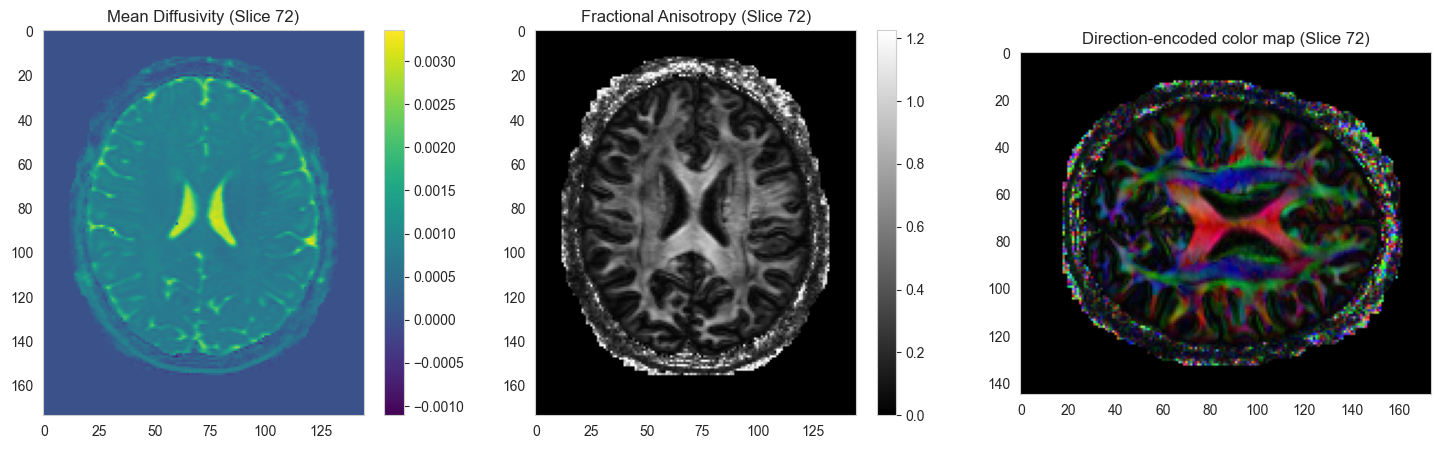

In [218]:
slice_idx = 71
MD_map, FA_map, D  = create_parameter_maps(dwis, bvals, qhat, slice_idx)
RGB_map = create_RGB_map(dwis, bvals, qhat, slice_idx)

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(np.flipud(MD_map.T), cmap='viridis')
plt.title('Mean Diffusivity (Slice 72)')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.flipud(FA_map.T), cmap='gray')
plt.title('Fractional Anisotropy (Slice 72)')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.flipud(RGB_map))
plt.title('Direction-encoded color map (Slice 72)')
# plt.figtext(0.6, 0.01, 'Transposing the color map was causing issues, so I have left it in the incorrect orientation.', wrap=True, fontsize=12)

plt.show()

$\Large{Q1.1.2}$

In [219]:
def ball_stick(x, bvals, qhat):
    # Behrens et al, 2003
    # Characterization and Propagation of Uncertainty in Diffusion-Weighted MR Imaging
    # https://doi.org/10.1002/mrm.10609
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f, theta, phi = x
    
    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
    return S

def BallStickSSD(x, voxel, bvals, qhat):
    S = ball_stick(x, bvals, qhat)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

In [220]:
# from scipy.optimize.optimize import fminunc  # Note: Python uses scipy.optimize.minimize instead
from scipy.optimize import minimize

# Get data from single voxel (as mentioned in coursework)
voxel = dwis[:,91,64,71]

# Starting point (as given in coursework)
startx = np.array([3500, -5e-6, 120, 0, 0])

# Define optimization options
options = {
    'maxiter': 200000,
    # 'ftol': 1e-10,
    # 'gtol': 1e-10,
    'maxfun': 20000
}

# Run optimization
result = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat), 
                 method='Nelder-Mead', options=options)

#print(result)
# Get fitted parameters
parameter_hat = result.x
residual_norm = result.fun

print("Fitted parameters:")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff: {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"theta: {parameter_hat[3]:.4e}")
print(f"phi: {parameter_hat[4]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")

Fitted parameters:
S0: 3.2604e+03
diff: -1.1048e-06
f: 4.5670e+02
theta: 7.1847e-02
phi: 1.6297e+00

Residual norm: 5.4699e+07


C:\Users\Gugu\AppData\Local\Temp\ipykernel_153640\4273706941.py:19: OptimizeWarning:

Unknown solver options: maxfun



In [221]:
"""Calculate expected RESNORM"""

# Number of measurements
n_measurements = len(voxel)  # 108 measurements
noise_std = 200

# Expected RESNORM given noise level
expected_resnorm = n_measurements * noise_std**2

# Actual RESNORM from our fit
actual_resnorm = result.fun

print(f"Number of measurements: {n_measurements}")
print(f"Expected RESNORM: {expected_resnorm:0.2e}")
print(f"Actual RESNORM: {actual_resnorm:0.2e}")
print(f"Ratio (Actual/Expected): {actual_resnorm/expected_resnorm:0.2f}")


Number of measurements: 108
Expected RESNORM: 4.32e+06
Actual RESNORM: 5.47e+07
Ratio (Actual/Expected): 12.66


In [222]:
# Generate model predictions
S_predicted = ball_stick(parameter_hat, bvals, qhat)

plot_model_fit(voxel, S_predicted, "Ball and Stick Prediction", marker_size=6)

$\Large{Q1.1.3}$

$\text{Transform parameters to be realistic values}$

In [223]:
def transform_parameters(x_transformed):
    """Transform parameters to enforce constraints"""
    S0 = x_transformed[0]**2  # Positive
    diff = x_transformed[1]**2  # Positive
    
    # Safer sigmoid implementation with clipping to avoid numerical issues
    f_transform = np.clip(x_transformed[2], -100, 100)  # Prevent overflow
    f = 1/(1 + np.exp(-f_transform))
    
    theta = x_transformed[3]
    phi = x_transformed[4]
    
    params = np.array([S0, diff, f, theta, phi])
    # print(f"Transformed parameters: {params}")  # Debug print
    return params

def ball_stick_constrained(x_transformed, bvals, qhat):
    """Takes unconstrained parameters and transforms them. Passes the transformed parameters 
    to the ball and stick model. Returns predicted signals from ball and stick."""
    # Transform parameters to enforce constraints
    x = transform_parameters(x_transformed)
    
    # Use original ball_stick with transformed parameters
    return ball_stick(x, bvals, qhat)

def BallStickSSD_constrained(x_transformed, voxel, bvals, qhat):
    """Calculates the sum of squared differences between the measured and predicted signals. Returnings the sum of errors."""
    S = ball_stick_constrained(x_transformed, bvals, qhat)
    return np.sum((voxel - S) ** 2)

In [ ]:

# Need to transform starting point to match constrained parameters
# If startx was [3500, -5e-6, 120, 0, 0]
# We need to invert the transformations:
# startx = np.array([3500, -5e-6, 120, 0, 0]) 

startx_transformed = np.array([
    np.sqrt(3500),          # sqrt for S0
    np.sqrt(5e-6),         # sqrt for diff (use positive value)
    0,                     # logit for f (start with f=0.5)
    0,                     # theta unchanged
    0                      # phi unchanged
])

bounds = [
    (-np.inf, np.inf),  # S0
    (-np.inf, np.inf),  # diff
    (-20, 20),         # f (sigmoid will map to ~0 to ~1)
    (-np.pi, np.pi),   # theta
    (-np.pi, np.pi)    # phi
]


# Run optimization with constrained version
result = minimize(BallStickSSD_constrained, 
                 startx_transformed, 
                 args=(voxel, bvals, qhat),
                 bounds=bounds,                 
                 method='L-BFGS-B',
                 options={'maxiter': 20000, 'ftol': 1e-10})


parameter_hat = transform_parameters(result.x)
residual_norm = result.fun
S_predicted = ball_stick(parameter_hat, bvals, qhat)


print("Fitted parameters (constrained):")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff: {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"theta: {parameter_hat[3]:.4e}")
print(f"phi: {parameter_hat[4]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")

plot_model_fit(voxel, S_predicted, "Ball and Stick Constrained Prediction", marker_size=8)

Fitted parameters (constrained):
S0: 4.2579e+03
diff: 1.1413e-03
f: 3.5731e-01
theta: -9.8107e-01
phi: 5.7945e-01

Residual norm: 5.8720e+06


TODO: MAYBE plot lines for the measured vs predicited b values.

$\text{Our residuals have decreased by a factor of 10, which is good. Now all our parameters are in the correct range and sign.}$

$\Large{Q1.1.4}$

$\text{Add random starting points based on a normal distribution of our original start parameters. Use a fitting loop to see which parameters.}$

In [ ]:
"""CREATE normally distributed random starts around our original start_x (S0=3500, etc...) """
def generate_random_starts(n_trials, base_params):
    """Generate random starting points around base parameters
    
    Args:
        n_trials: Number of random starting points to generate
        base_params: Base parameters [S0, diff, f, theta, phi]
    """
    stds = [
        0.1 * base_params[0],
        0.1 * base_params[1],
        0.1, 
        np.pi/8,             
        np.pi/8
    ]

    random_starts = np.zeros((n_trials, 5))
    for i in range(5):
        random_starts[:,i] = np.random.normal(
            loc=base_params[i], 
            scale=stds[i], 
            size=n_trials
        )
    
    return random_starts

Success rate of finding global minimum: 100.0%

Best fit parameters:
S0: 4.2579e+03
diff: 1.1413e-03
f: 3.5731e-01
theta: 9.8107e-01
phi: -2.5621e+00
Residual norm: 5.8720e+06


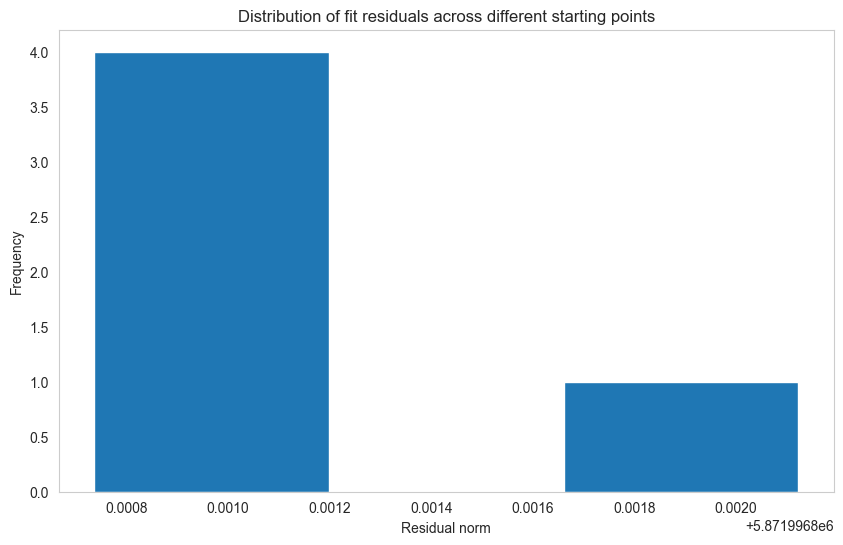

In [ ]:
def generate_starting_points(n_trials, base_point):
    """
    Generate n_trials starting points by adding Gaussian noise to base_point.
    Scale of noise should reflect scale of each parameter.
    """
    scales = np.array([
        np.sqrt(3500) * 0.1,   
        np.sqrt(5e-6) * 0.1,    
        1.0,
        np.pi/4,                
        np.pi/4
    ])
    
    # Generate starting points
    starting_points = np.zeros((n_trials, 5))
    for i in range(n_trials):
        noise = np.random.normal(0, 1, 5) * scales
        starting_points[i] = base_point + noise
    
    return starting_points

def fit_multiple_starts(voxel, bvals, qhat, model_to_fit,  n_trials=5):
    """
    Fit ball-stick model multiple times with different starting points.
    Returns all results and identifies how often we find the global minimum.
    """
    # Base starting point (transformed space)
    base_start = np.array([
        np.sqrt(3500),      # S0
        np.sqrt(5e-6),      # diff
        0,                  # f (transforms to 0.5) 
        0,                  # theta
        0                   # phi
    ])
    
    # Generate starting points
    starting_points = generate_starting_points(n_trials, base_start)
    
    # Store results
    all_results = []
    all_resnorms = []
    
    # Fit from each starting point
    for i in range(n_trials):
        result = minimize(model_to_fit, 
                        starting_points[i], 
                        args=(voxel, bvals, qhat),
                        method='L-BFGS-B',
                        bounds=bounds,
                        options={'maxiter': 20000, 'ftol': 1e-10})
        
        all_results.append(result)
        all_resnorms.append(result.fun)
    
    # Find best result and count how often we find it
    best_resnorm = np.min(all_resnorms)
    tolerance = 1  # Define what we consider "same" minimum
    n_global = np.sum(np.abs(all_resnorms - best_resnorm) < tolerance)
    
    # Get best result
    best_idx = np.argmin(all_resnorms)
    best_result = all_results[best_idx]
    
    return best_result, n_global/n_trials, all_results

# Run the multiple start fitting
best_fit, success_rate, all_fits = fit_multiple_starts(voxel, bvals, qhat, BallStickSSD_constrained)

# Print results
print(f"Success rate of finding global minimum: {success_rate*100:.1f}%")
print("\nBest fit parameters:")
best_params = transform_parameters(best_fit.x)
print(f"S0: {best_params[0]:.4e}")
print(f"diff: {best_params[1]:.4e}")
print(f"f: {best_params[2]:.4e}")
print(f"theta: {best_params[3]:.4e}")
print(f"phi: {best_params[4]:.4e}")
print(f"Residual norm: {best_fit.fun:.4e}")

# Visualize distribution of residual norms
plt.figure(figsize=(10,6))
plt.hist([fit.fun for fit in all_fits], bins=3)
plt.xlabel('Residual norm')
plt.ylabel('Frequency')
plt.title('Distribution of fit residuals across different starting points')
plt.show()

In [109]:
p = 0.75
n = np.log(0.05)/np.log(1-p)
print(f"Trials needed for 95% confidence: {np.ceil(n)}")

Trials needed for 95% confidence: 3.0


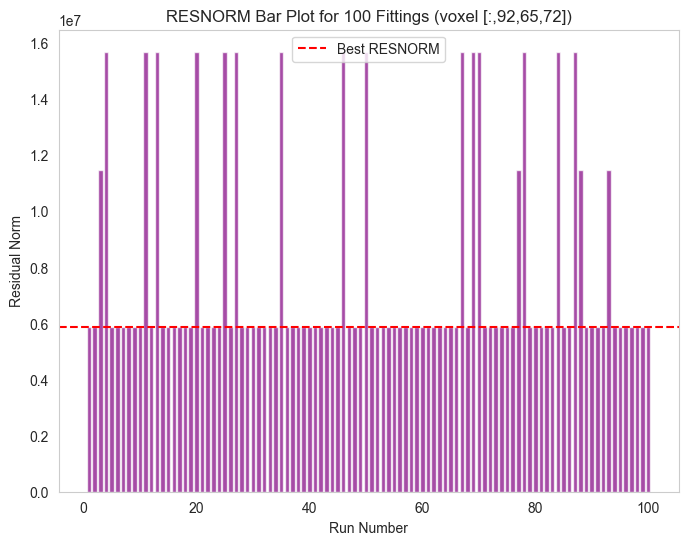

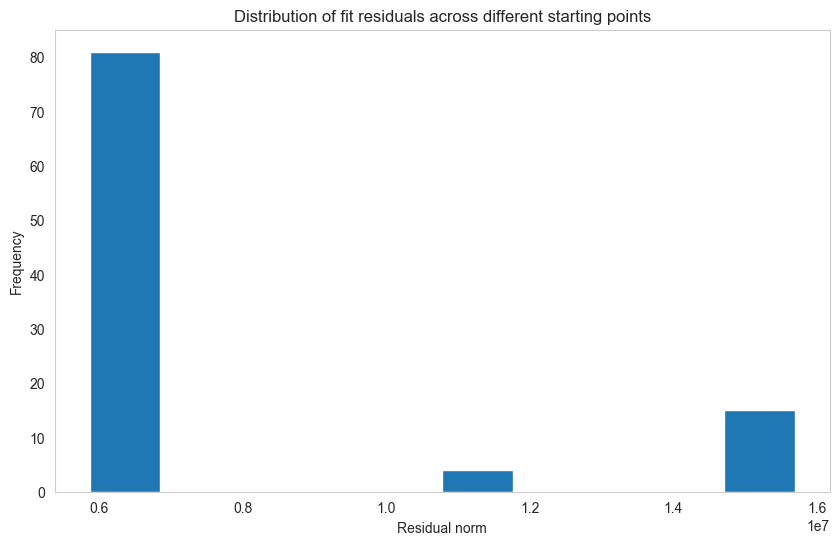

VOXEL: [:,91,64,71]
Number of trials: 100
Minimum RESNORM: 5.87e+06
Mean RESNORM: 7.57e+06
Success rate: 81.0%
Number of solutions within 0.1% of minimum: 81 
Trials needed for 95% confidence: 2.0

VOXEL: [:,93,63,71]
Number of trials: 100
Minimum RESNORM: 5.69e+06
Mean RESNORM: 8.85e+06
Success rate: 71.0%
Number of solutions within 0.1% of minimum: 71 
Trials needed for 95% confidence: 3.0

VOXEL: [:,89,34,71]
Number of trials: 100
Minimum RESNORM: 7.96e+06
Mean RESNORM: 8.65e+06
Success rate: 62.0%
Number of solutions within 0.1% of minimum: 63 
Trials needed for 95% confidence: 4.0

VOXEL: [:,60,65,71]
Number of trials: 100
Minimum RESNORM: 4.61e+06
Mean RESNORM: 1.10e+07
Success rate: 71.0%
Number of solutions within 0.1% of minimum: 71 
Trials needed for 95% confidence: 3.0



In [237]:

import matplotlib.pyplot as plt
import numpy as np

voxel_indices = [
    (91, 64, 71),  # Original voxel
    (93, 63, 71),  # Second voxel
    (89, 34, 71),  # Third voxel 
    (60, 65, 71)   # Fourth voxel
]

for voxel_index in voxel_indices:
    n_trials = 100
    i, j, k = voxel_index  # Get indices for first voxel
    voxel = dwis[:, i, j, k]
    best_fit, success_rate, all_fits = fit_multiple_starts(voxel, bvals, qhat, BallStickSSD_constrained, n_trials=n_trials)

    # Extract residual norms
    residual_norms = [fit.fun for fit in all_fits]
    
    p = success_rate
    n = np.log(0.05)/np.log(1-p)

    if i == 91:
        
        # Plot residual norm comparison
        all_resnorms = []
        for fit in all_fits:
            all_resnorms.append(fit.fun)
        plt.figure(figsize=(8, 6))
        plt.bar(range(1, n_trials + 1), all_resnorms, color='purple', alpha=0.7)
        plt.axhline(y=best_fit.fun, color='red', linestyle='dashed', label="Best RESNORM")
        plt.xlabel('Run Number')
        plt.ylabel('Residual Norm')
        plt.title('RESNORM Bar Plot for 100 Fittings (voxel [:,92,65,72])')
        # plt.xticks(range(1, ))
        plt.legend()
        plt.show()        
            # Visualize distribution of residual norms
        plt.figure(figsize=(10,6))
        plt.hist([fit.fun for fit in all_fits], bins=10)
        plt.xlabel('Residual norm')
        plt.ylabel('Frequency')
        plt.title('Distribution of fit residuals across different starting points')
        plt.show()
    # Create figure with two subplots
    stats_text = (
        f'VOXEL: [:,{i},{j},{k}]\n'        
        f'Number of trials: {len(residual_norms)}\n'
        f'Minimum RESNORM: {min(residual_norms):.2e}\n'
        f'Mean RESNORM: {np.mean(residual_norms):.2e}\n'
        f'Success rate: {success_rate*100:.1f}%\n'
        f'Number of solutions within 0.1% of minimum: '
        f'{sum(norm <= min(residual_norms)*1.001 for norm in residual_norms)} \n'
        f'Trials needed for 95% confidence: {np.ceil(n)}\n'
    )

    print(stats_text)

$\text{Calculate the number of trials requried to be 95\% sure}$

$$0.25^{n} = 0.05$$
$$log(0.25^{n}) = log(0.05)$$
$$n = log(0.05) / log(0.25)$$

$$n = 4.75 $$

After 100 trials, we find that ~78% of the RESNORMs are in the 6e6 bin. We need a minimum of 5 trials to be 95% confident that we have found a global minimum. I have exceeded that with 100 trials.  

$\Large{Q1.1.5}$

<h2>Create parameters maps over slice 72

In [440]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import minimize
from joblib import Parallel, delayed
from tqdm import tqdm
import math

def ball_stick(x, bvals, qhat):
    S0 = x[0] ** 2  # Ensure S0 > 0
    diff = x[1] ** 2  # Ensure diff > 0
    f_transform = np.clip(x[2], -100, 100)  # Prevent overflow
    f = 1/(1 + np.exp(-f_transform))    
    # f = 1 / (1 + np.exp(-x[2]))  # Maps f to [0,1]
    theta = np.pi * (1 / (1 + np.exp(-x[3])))  # Maps theta to [0, π]
    phi = 2 * np.pi * (1 / (1 + np.exp(-x[4])))  # Maps phi to [0, 2π]

    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    # Make sure qhat is properly shaped for dot product
    # qhat_reshaped = qhat.T if qhat.shape[0] == 3 else qhat
    # fibdotgrad = np.einsum('ij,j->i', qhat_reshaped, fibdir)
    fibdotgrad = np.einsum('ij,ij->i', qhat, np.tile(fibdir, (len(bvals), 1)))
    
    # fibdotgrad = np.einsum('ij,ij->i', qhat.T, np.tile(fibdir, (len(bvals), 1)))

    # Signal model
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1 - f) * np.exp(-bvals * diff))
    return S

def BallStickSSD(x, voxel, bvals, qhat):
    S = ball_stick(x, bvals, qhat)
    return np.sum((voxel - S) ** 2)

def optimize_voxel(i, j, dwi, slice_idx, bvals, qhat, num_restarts=1, tol=1e-10):
    """
    Optimizes a single voxel and returns its parameters, residual norm, and percentage minima.
    """
    voxel = dwi[:,i,j,slice_idx]
    if np.min(voxel) <= 0:  # Skip if voxel has non-positive values
        return i, j, None, None, None

    best_residual = np.inf
    best_parameters = None
    resnorm_list = []

    for _ in range(num_restarts):
        startx = np.array([
        # np.sqrt(3500),      # S0
        # np.sqrt(5e-6),      # diff            
            np.sqrt(np.random.uniform(1000, 4000)),  # Random S0
            np.sqrt(np.random.uniform(0.0001, 0.002)),  # Random diff
            # 0,
            # 0,
            # 0
            np.random.uniform(-2, 2),  # f
            np.random.uniform(-2, 2),  # theta
            np.random.uniform(-2, 2)   # phi
        ])
        
        # bounds = [
        #     (-np.inf, np.inf),  # S0
        #     (-np.inf, 0.1),  # diff
        #     (-20, 20),         # f (sigmoid will map to ~0 to ~1)
        #     (-np.pi, np.pi),   # theta
        #     (-np.pi, np.pi)    # phi
        # ]
        
        options = {
            'maxiter': 20000,
            'ftol': 1e-8,      # Looser tolerance
            'eps': 1e-8,       # Adjust gradient approximation step
            'maxfun': 20000    # Allow more function evaluations
        }
        # result_nm = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat), method='Nelder-Mead', options={'maxiter':1000})
        # result = minimize(BallStickSSD, result_nm.x, args=(voxel, bvals, qhat),  method='L-BFGS-B', options=options)

        result = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat),
                        # method='L-BFGS-B',
                        method='Nelder-Mead',
                        options = {
                            # 'maxiter': 1000,
                            # 'xatol': 1e-8,
                            # 'fatol': 1e-10
                        },
                        # bounds=bounds
                        )

        resnorm_list.append(result.fun)

        if result.fun < best_residual:
            best_residual = result.fun
            best_parameters = result.x

    global_minima = np.min(resnorm_list)
    count_minima = np.count_nonzero(np.isclose(resnorm_list, global_minima, atol=tol))

    return i, j, best_parameters, global_minima, count_minima / num_restarts
    

def optimize_slice(dwi, bvals, qhat, slice_idx, num_restarts=1):
    """
    Runs constrained optimization over a full slice using parallel processing.
    """
    Dx, Dy = dwi.shape[1:3]
    
    # Create list of voxel coordinates to process
    coords = [(i, j) for i in range(Dx) for j in range(Dy)]
    
    # Run parallel optimization
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(optimize_voxel)(i, j, dwi, slice_idx, bvals, qhat, num_restarts)
        for i, j in tqdm(coords)
    )

    # Initialize storage arrays
    param_maps = np.zeros((5, Dx, Dy))  # Stores S0, d, f, theta, phi
    resnorm_map = np.zeros((Dx, Dy))
    perc_min_map = np.zeros((Dx, Dy))

    # Store results
    for i, j, params, global_minima, count_minima in results:
        if params is not None:
            param_maps[:, i, j] = params
            resnorm_map[i, j] = global_minima
            perc_min_map[i, j] = count_minima

    return param_maps, resnorm_map, perc_min_map

def run_analysis(dwis, bvals, qhat, slice_idx=71, num_restarts=1):
    param_maps, resnorm_map, perc_min_map = optimize_slice(dwis, bvals, qhat, slice_idx, num_restarts)

    # Transform parameters back to original scale
    S0_map = param_maps[0] ** 2
    d_map = param_maps[1] ** 2
    f_map = 1 / (1 + np.exp(-param_maps[2]))
    theta_map = np.pi * (1 / (1 + np.exp(-param_maps[3])))
    phi_map = 2 * np.pi * (1 / (1 + np.exp(-param_maps[4])))

    return S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_fiber_directions(n_x, n_y, f_map, d_map, threshold=1e-4):
    Dx, Dy = n_x.shape
    X, Y = np.meshgrid(np.arange(Dx), np.arange(Dy))
    
    # Create mask for brain tissue based on diffusivity
    brain_mask = d_map > threshold
    
    # Apply mask to directional components and coordinates
    mask_indices = np.where(brain_mask.T)  # Transpose to match quiver coordinates
    X_masked = X[mask_indices]
    Y_masked = Y[mask_indices]
    U_masked = n_x.T[mask_indices]
    V_masked = n_y.T[mask_indices]
    
    
    skip=2
    # Downsample everything
    X_masked = X_masked[::skip]
    Y_masked = Y_masked[::skip]
    U_masked = U_masked[::skip]
    V_masked = V_masked[::skip]
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Plot background volume fraction map
    plt.imshow(f_map.T, cmap='gray', origin='lower', alpha=0.7)
    
    # Plot quiver only for brain voxels
    plt.quiver(X_masked, Y_masked, U_masked, V_masked, 
              angles='xy', scale_units='xy', scale=0.06, 
              headwidth=5, color="purple", alpha=.7)
    
    plt.title("Volume Fraction (f) Map with overlayed Fiber Direction Map", fontsize=16)
    plt.xlabel("Voxel X")
    plt.ylabel("Voxel Y")
    plt.gca().invert_yaxis()
    plt.show()

def plot_parameter_maps(S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map):
    # Set the style with seaborn
    sns.set_style("white")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Create figure with more precise control over spacing
    fig = plt.figure(figsize=(20, 10))
    gs = plt.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.3)
    
    # Maps configuration
    maps = [
        ('S0 Map', S0_map, 'viridis', [0, 17500], gs[0, 0]),
        ('Diffusivity Map', d_map, 'viridis', [0, 0.003], gs[0, 1]),
        ('Volume Fraction Map', f_map, 'RdYlBu_r', [0, 1.0], gs[0, 2]),
        ('Residual Norm Map', resnorm_map, 'coolwarm', [0, 2.5e7], gs[0, 3]),
        ('Global Minima %', perc_min_map, 'YlOrRd', [0, 1.0], gs[1, 0]),
        ('Theta Map', theta_map, 'magma', [0, 3.0], gs[1, 1]),
        ('Phi Map', phi_map, 'magma', [0, 6.0], gs[1, 2])
    ]
    
    axes = []
    for title, data, cmap, vlim, pos in maps:
        ax = fig.add_subplot(pos)
        
        # Create heatmap with consistent color scaling
        im = ax.imshow(np.flipud(data.T), cmap=cmap, vmin=vlim[0], vmax=vlim[1])
        
        # Add colorbar with smaller width
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        # Customize title and appearance
        ax.set_title(title, pad=10, fontsize=12, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add subtle border
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#cccccc')
            
        axes.append(ax)
    
    # Add main title with better positioning
    fig.suptitle('Ball and Stick Model Parameter Maps', 
                fontsize=16, 
                fontweight='bold',
                y=0.95)
    
    return fig

In [240]:
maps = run_analysis(dwis, bvals, qhat, slice_idx=71, num_restarts=5)
S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map = maps

100%|██████████| 25230/25230 [05:23<00:00, 78.00it/s]  
C:\Users\Gugu\AppData\Local\Temp\ipykernel_153640\289457176.py:142: RuntimeWarning:

overflow encountered in exp

C:\Users\Gugu\AppData\Local\Temp\ipykernel_153640\289457176.py:143: RuntimeWarning:

overflow encountered in exp



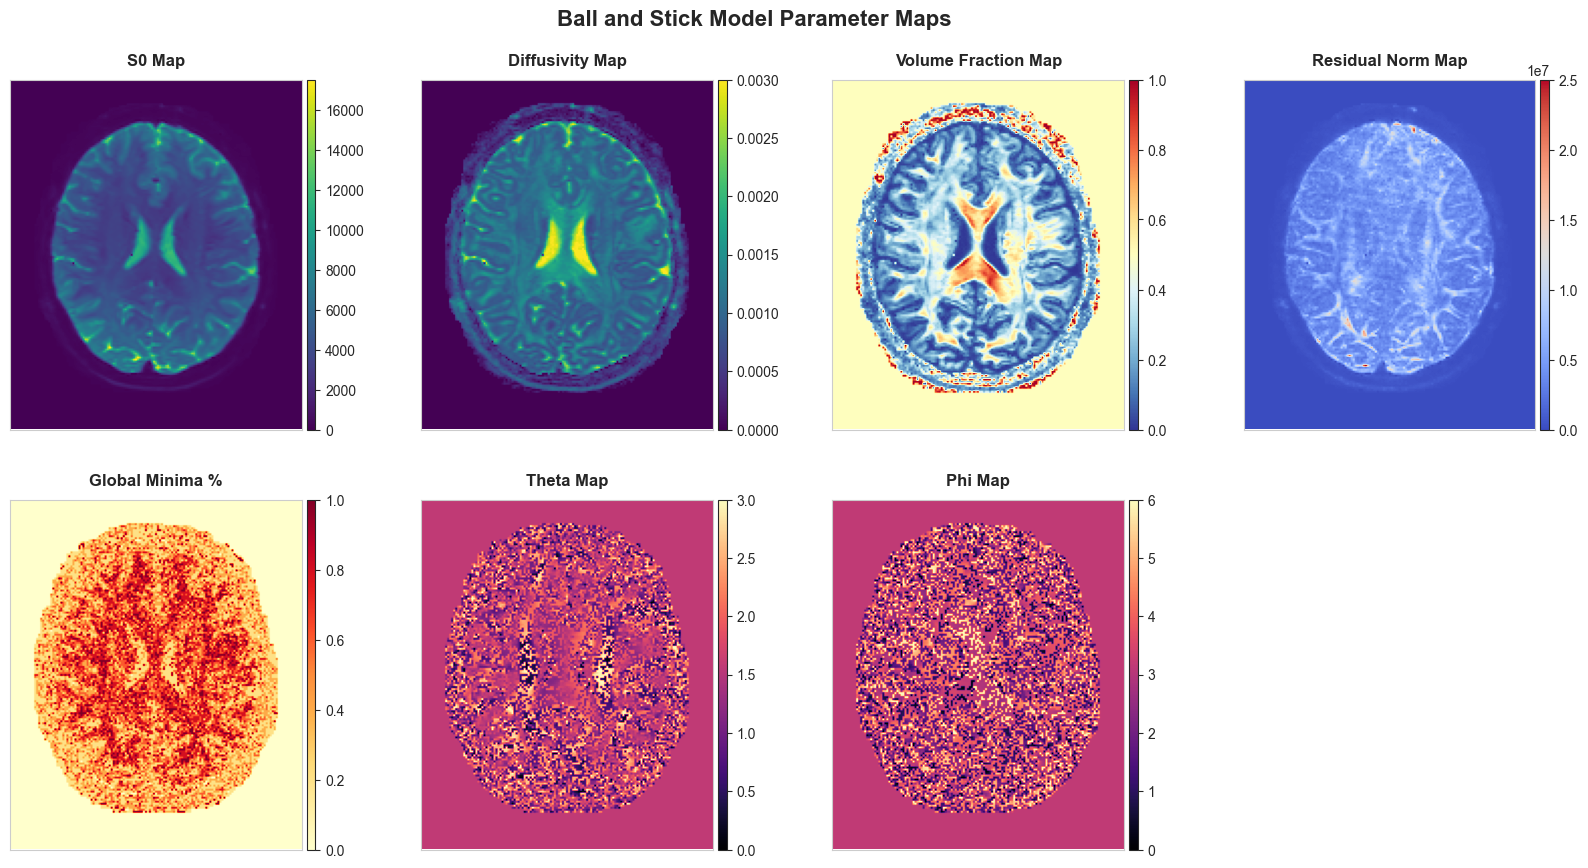

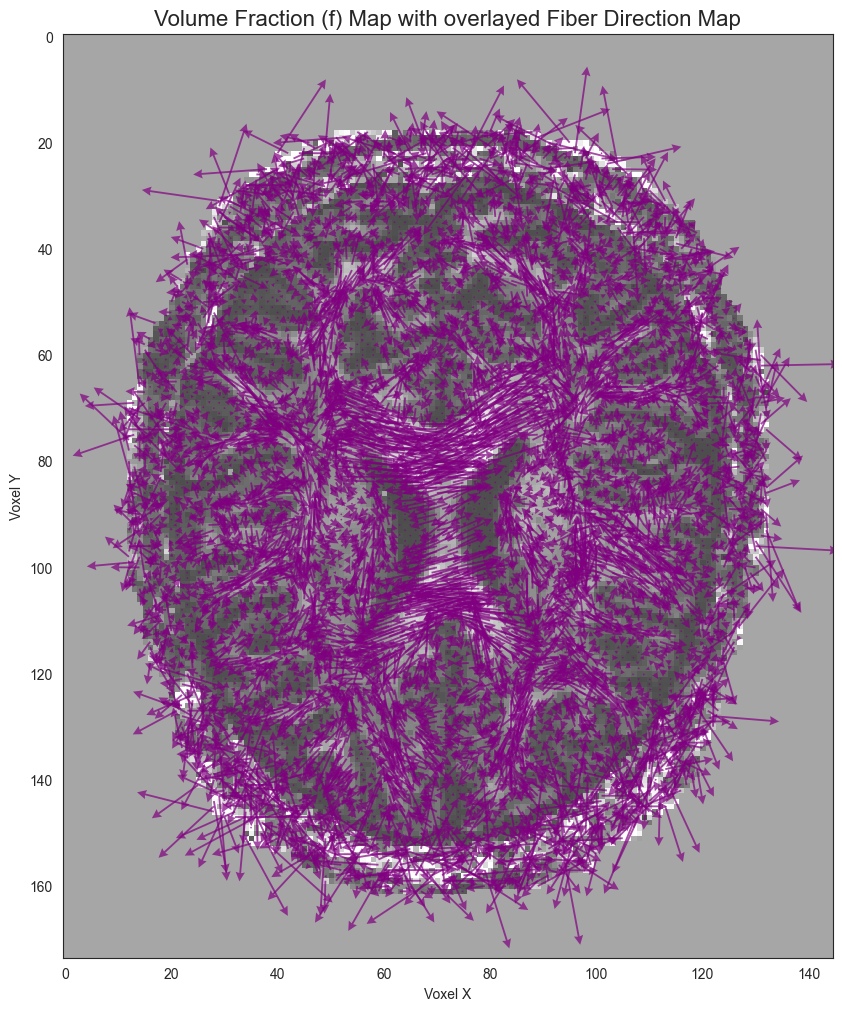

In [256]:
# S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map = maps
# Plot results
plot_parameter_maps(S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map)
    
# Plot fiber directions
n_x = f_map * np.sin(theta_map) * np.cos(phi_map)
n_y = f_map * np.sin(theta_map) * np.sin(phi_map)
plot_fiber_directions(n_x, n_y, f_map, d_map)

$\Large{Q1.1.7} - \text{Rician Noise Model}$





























































































































































































































































































































































































































































































































































































































































































100%|██████████| 25230/25230 [00:55<00:00, 453.43it/s] 
C:\Users\Gugu\AppData\Local\Temp\ipykernel_153640\3444890630.py:169: RuntimeWarning:

overflow encountered in exp

C:\Users\Gugu\AppData\Local\Temp\ipykernel_153640\3444890630.py:170: RuntimeWarning:

overflow encountered in exp



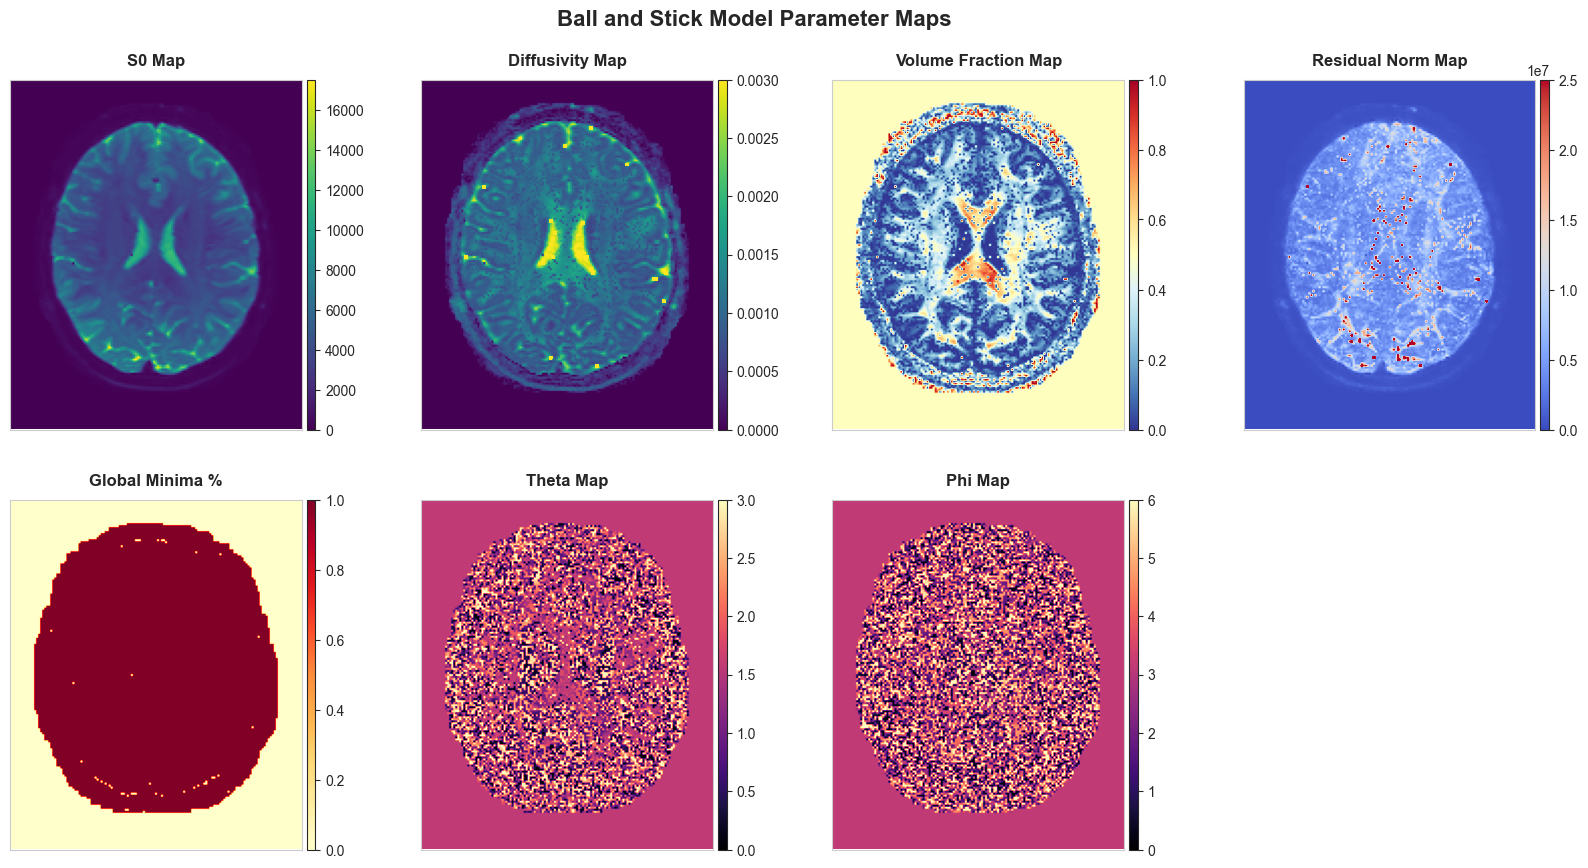

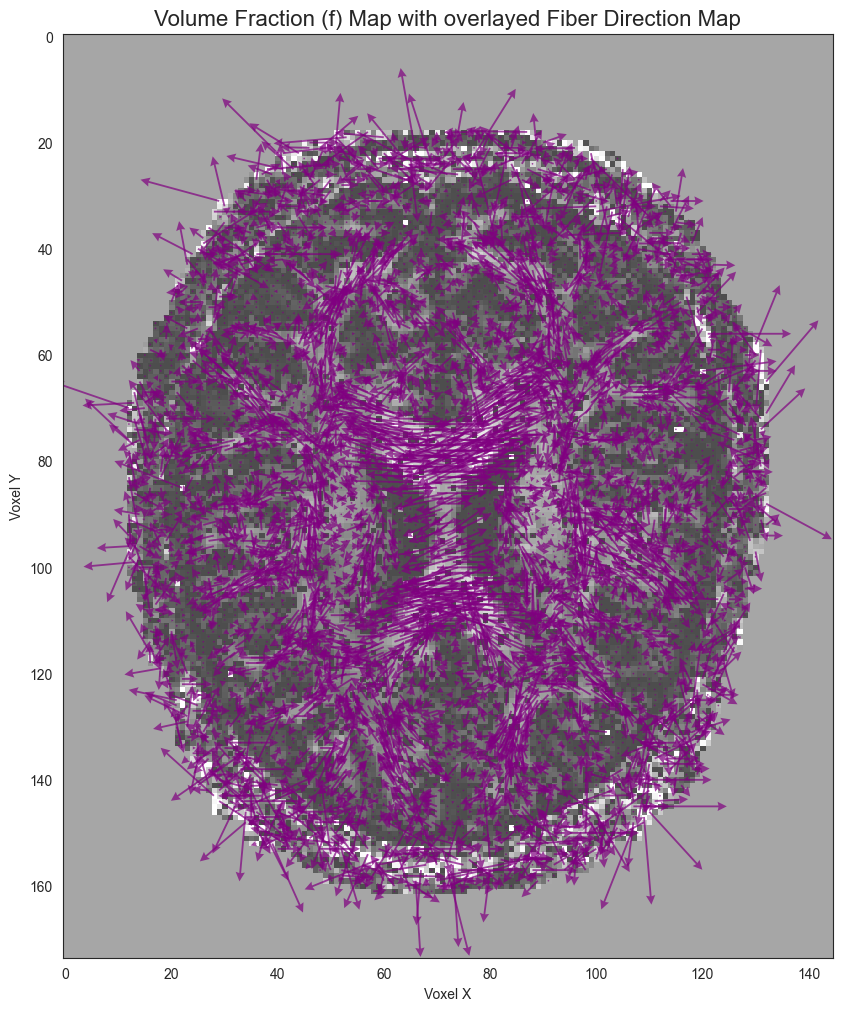

In [ ]:
from scipy.special import iv
from tqdm import tqdm

def ball_stick_rician(x, bvals, qhat):
    S0 = x[0] ** 2  
    diff = x[1] ** 2
    f_transform = np.clip(x[2], -100, 100)
    f = 1/(1 + np.exp(-f_transform))    
    theta = np.pi * (1 / (1 + np.exp(-x[3])))
    phi = 2 * np.pi * (1 / (1 + np.exp(-x[4])))

    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    fibdotgrad = np.einsum('ij,ij->i', qhat, np.tile(fibdir, (len(bvals), 1)))

    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1 - f) * np.exp(-bvals * diff))
    return S

def BallStickRicianNLL(x, voxel, bvals, qhat, sigma=0.04):
    """
    Negative log-likelihood for Rician noise model
    
    Args:
        x: Model parameters
        voxel: Observed signals
        bvals, qhat: Diffusion encoding
        sigma: Noise standard deviation
    """
    # Get model predictions
    S = ball_stick_rician(x, bvals, qhat)
    
    M = voxel  # Measured signals
    A = S      # Predicted signals
    
    # Compute negative log-likelihood (ignoring constant terms)
    nll = np.sum(
        (M**2 + A**2)/(2*sigma**2) - 
        np.log(M/sigma**2) - 
        np.log(iv(0, M*A/sigma**2))
    )
    
    return nll

# Simple approximation of Rician likelihood (from Alexander 2009)
def BallStickRicianApprox(x, voxel, bvals, qhat, sigma=0.04):
    """
    Approximation of Rician noise model using offset Gaussian
    
    For high SNR (>2), Rician distribution approaches Gaussian with 
    mean sqrt(A² + σ²) where A is the true signal
    """
    S = ball_stick_rician(x, bvals, qhat)
    
    # Offset predictions to account for Rician bias
    S_offset = np.sqrt(S**2 + sigma**2)
    
    return np.sum((voxel - S_offset)**2)


def optimize_voxel_rician(i, j, dwi, slice_idx, bvals, qhat, num_restarts=1, tol=1e-10):
    """
    Optimizes a single voxel and returns its parameters, residual norm, and percentage minima.
    """
    voxel = dwi[:,i,j,slice_idx]
    if np.min(voxel) <= 0:  # Skip if voxel has non-positive values
        return i, j, None, None, None

    best_residual = np.inf
    best_parameters = None
    resnorm_list = []

    for _ in range(num_restarts):
        startx = np.array([
        # np.sqrt(3500),      # S0
        # np.sqrt(5e-6),      # diff            
            np.sqrt(np.random.uniform(1000, 4000)),  # Random S0
            np.sqrt(np.random.uniform(0.0001, 0.002)),  # Random diff
            # 0,
            # 0,
            # 0
            np.random.uniform(-2, 2),  # f
            np.random.uniform(-2, 2),  # theta
            np.random.uniform(-2, 2)   # phi
        ])
        
        # bounds = [
        #     (-np.inf, np.inf),  # S0
        #     (-np.inf, 0.1),  # diff
        #     (-20, 20),         # f (sigmoid will map to ~0 to ~1)
        #     (-np.pi, np.pi),   # theta
        #     (-np.pi, np.pi)    # phi
        # ]
        
        options = {
            'maxiter': 20000,
            'ftol': 1e-8,      # Looser tolerance
            'eps': 1e-8,       # Adjust gradient approximation step
            'maxfun': 20000    # Allow more function evaluations
        }
        # result_nm = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat), method='Nelder-Mead', options={'maxiter':1000})
        # result = minimize(BallStickSSD, result_nm.x, args=(voxel, bvals, qhat),  method='L-BFGS-B', options=options)

        result = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat),
                        # method='L-BFGS-B',
                        method='Nelder-Mead',
                        options = {
                            'maxiter': 2000,
                            # 'xatol': 1e-8,
                            # 'fatol': 1e-10
                        },
                        # bounds=bounds
                        )

        resnorm_list.append(result.fun)

        if result.fun < best_residual:
            best_residual = result.fun
            best_parameters = result.x

    global_minima = np.min(resnorm_list)
    count_minima = np.count_nonzero(np.isclose(resnorm_list, global_minima, atol=tol))

    return i, j, best_parameters, global_minima, count_minima / num_restarts

def optimize_slice(dwi, bvals, qhat, slice_idx, num_restarts=1):
    """
    Runs constrained optimization over a full slice using parallel processing.
    """
    Dx, Dy = dwi.shape[1:3]
    
    # Create list of voxel coordinates to process
    coords = [(i, j) for i in range(Dx) for j in range(Dy)]
    
    # Run parallel optimization
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(optimize_voxel_rician)(i, j, dwi, slice_idx, bvals, qhat, num_restarts)
        for i, j in tqdm(coords)
    )

    param_maps = np.zeros((5, Dx, Dy))  # Stores S0, d, f, theta, phi
    resnorm_map = np.zeros((Dx, Dy))
    perc_min_map = np.zeros((Dx, Dy))

    # Store results
    for i, j, params, global_minima, count_minima in results:
        if params is not None:
            param_maps[:, i, j] = params
            resnorm_map[i, j] = global_minima
            perc_min_map[i, j] = count_minima

    return param_maps, resnorm_map, perc_min_map

def run_analysis(dwis, bvals, qhat, slice_idx=71, num_restarts=1):
    param_maps, resnorm_map, perc_min_map = optimize_slice(dwis, bvals, qhat, slice_idx, num_restarts)

    # Transform parameters back to original scale
    S0_map = param_maps[0] ** 2
    d_map = param_maps[1] ** 2
    f_map = 1 / (1 + np.exp(-param_maps[2]))
    theta_map = np.pi * (1 / (1 + np.exp(-param_maps[3])))
    phi_map = 2 * np.pi * (1 / (1 + np.exp(-param_maps[4])))

    return S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map

maps = run_analysis(dwis, bvals, qhat, slice_idx=71, num_restarts=1)
S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map = maps

# S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map = maps
# Plot results
plot_parameter_maps(S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map)
    
# Plot fiber directions
n_x = f_map * np.sin(theta_map) * np.cos(phi_map)
n_y = f_map * np.sin(theta_map) * np.sin(phi_map)
plot_fiber_directions(n_x, n_y, f_map, d_map)



# Q1.2 - Uncertainty Estimation

$\Large{Q1.2.1}$


95% ranges:
S0: [2.195e+03, 2.815e+03]
d: [1.552e-17, 4.007e-04]
f: [4.687e-01, 1.000e+00]

2-sigma ranges (95% confidence intervals):
S0: [2.195e+03, 2.815e+03]
d: [1.552e-17, 4.007e-04]
f: [4.687e-01, 1.000e+00]


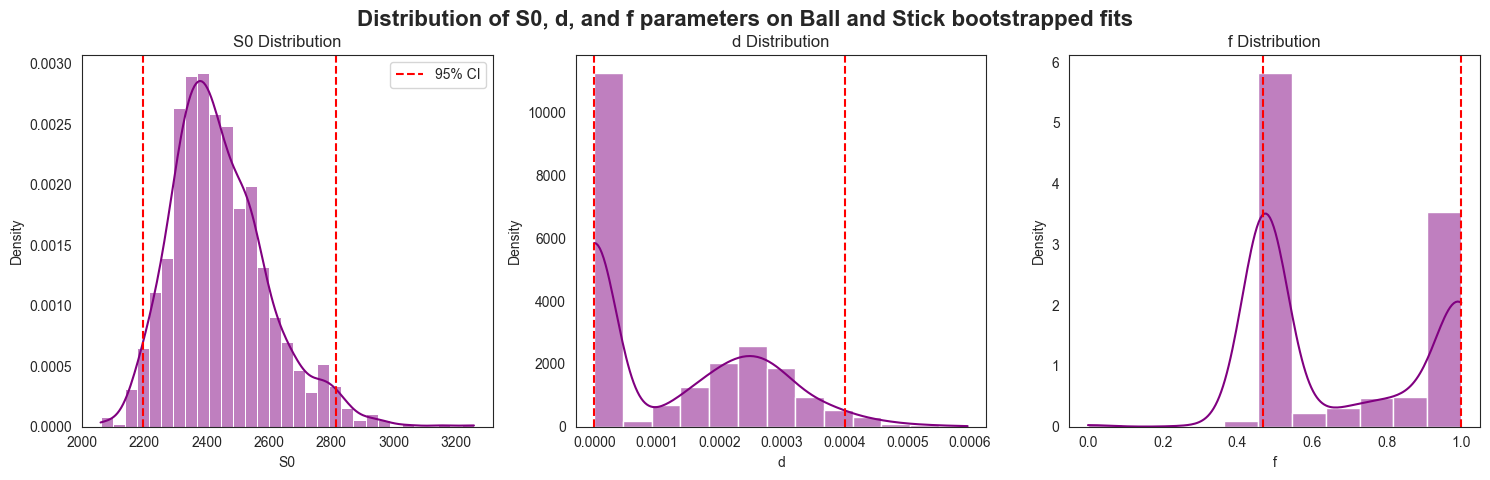

In [ ]:
def ball_stick_bootstrap(x, bvals, qhat):
    S0 = x[0] ** 2  # Ensure S0 > 0
    diff = x[1] ** 2  # Ensure diff > 0
    f_transform = np.clip(x[2], -100, 100)  # Prevent overflow
    f = 1/(1 + np.exp(-f_transform))    
    # f = 1 / (1 + np.exp(-x[2]))  # Maps f to [0,1]
    theta = np.pi * (1 / (1 + np.exp(-x[3])))  # Maps theta to [0, π]
    phi = 2 * np.pi * (1 / (1 + np.exp(-x[4])))  # Maps phi to [0, 2π]

    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    fibdotgrad = np.einsum('ij,ij->i', qhat, np.tile(fibdir, (len(bvals), 1)))
    
    # fibdotgrad = np.einsum('ij,ij->i', qhat.T, np.tile(fibdir, (len(bvals), 1)))

    # Signal model
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1 - f) * np.exp(-bvals * diff))
    return S

def BallStickSSD_constrained_bootstrap(x, voxel, bvals, qhat):
    S = ball_stick(x, bvals, qhat)
    return np.sum((voxel - S) ** 2)

def bootstrap_ballstick(voxel, bvals, qhat, n_bootstraps=1000):
    """
    Perform bootstrap estimation of ball-and-stick parameters
    Returns parameter distributions and confidence intervals for S0, d, and f only
    """
    n_measurements = len(voxel)
    bootstrap_params = np.zeros((n_bootstraps, 3))
    base_S0 = 3500
    base_diff = 0.001  # 1e-3 mm²/s
    base_f = 0.5
    
    std_S0 = 0.1 * base_S0
    std_diff = 0.1 * base_diff
    std_f = 0.1  # For f we use fixed std since it's in logit space
    
    startx = np.array([
        np.sqrt(np.random.normal(base_S0, std_S0)),     # S0 (positive)
        np.sqrt(np.random.normal(base_diff, std_diff)),  # d (positive)
        np.random.normal(0, std_f),                      # f (logit space, 0 corresponds to f=0.5)
        np.random.normal(0, np.pi/8),                    # theta
        np.random.normal(0, np.pi/8)                     # phi
    ])  
    
    bounds = [
        (-np.inf, np.inf),  # S0
        (-np.inf, np.inf),  # diff
        (-20, 20),         # f 
        (-np.pi, np.pi),   # theta
        (-np.pi, np.pi)    # phi
    ]
    
    # Perform bootstrap iterations
    for i in range(n_bootstraps):
        # Generate bootstrap sample by random resampling with replacement
        indices = np.random.randint(0, n_measurements, n_measurements)
        bootstrap_sample = voxel[indices]
        # bootstrap_bvals = bvals[indices]
        # bootstrap_qhat = qhat[indices]
        
        # Fit model to bootstrap sample
        result = minimize(BallStickSSD_constrained_bootstrap, 
                        startx,
                        # args=(bootstrap_sample, bootstrap_bvals, bootstrap_qhat),
                        args=(bootstrap_sample, bvals, qhat),
                        method='Nelder-Mead',
                        bounds=bounds)
        
        # Store transformed parameters (only S0, d, f)
        params = transform_parameters(result.x)
        bootstrap_params[i] = params[:3]  # Only keep S0, d, f
        
    # Calculate confidence intervals
    two_sigma = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)  # 95% CI (2-sigma)
    ninety_five = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)  # 95% range
    
    return bootstrap_params, two_sigma, ninety_five

# Run bootstrap analysis for our test voxel
voxel = dwis[:,91,64,71]
bootstrap_params, two_sigma, ninety_five = bootstrap_ballstick(voxel, bvals, qhat)

# Print results
param_names = ['S0', 'd', 'f']

print("\n95% ranges:")
for i, name in enumerate(param_names):
    print(f"{name}: [{ninety_five[0,i]:.3e}, {ninety_five[1,i]:.3e}]")

print("\n2-sigma ranges (95% confidence intervals):")
for i, name in enumerate(param_names):
    print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")

# Visualize distributions using seaborn
fig = plt.figure(figsize=(15, 5))
for i, name in enumerate(param_names):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=bootstrap_params[:,i], stat='density', kde=True, color="purple")
    plt.axvline(two_sigma[0,i], color='r', linestyle='--', label='95% CI')
    plt.axvline(two_sigma[1,i], color='r', linestyle='--')
    plt.title(f'{name} Distribution')
    plt.xlabel(name)
    if i == 0:
        plt.legend()

fig.suptitle('Distribution of S0, d, and f parameters on Ball and Stick bootstrapped fits', 
            fontsize=16, 
            fontweight='bold',
            y=0.95)
plt.tight_layout()
plt.show()

VOXEL: [:,91,64,71]


95% ranges:
S0: [2.212e+03, 2.792e+03]
d: [2.095e-17, 4.023e-04]
f: [4.101e-01, 1.000e+00]

2-sigma ranges (95% confidence intervals):
S0: [2.212e+03, 2.792e+03]
d: [2.095e-17, 4.023e-04]
f: [4.101e-01, 1.000e+00]


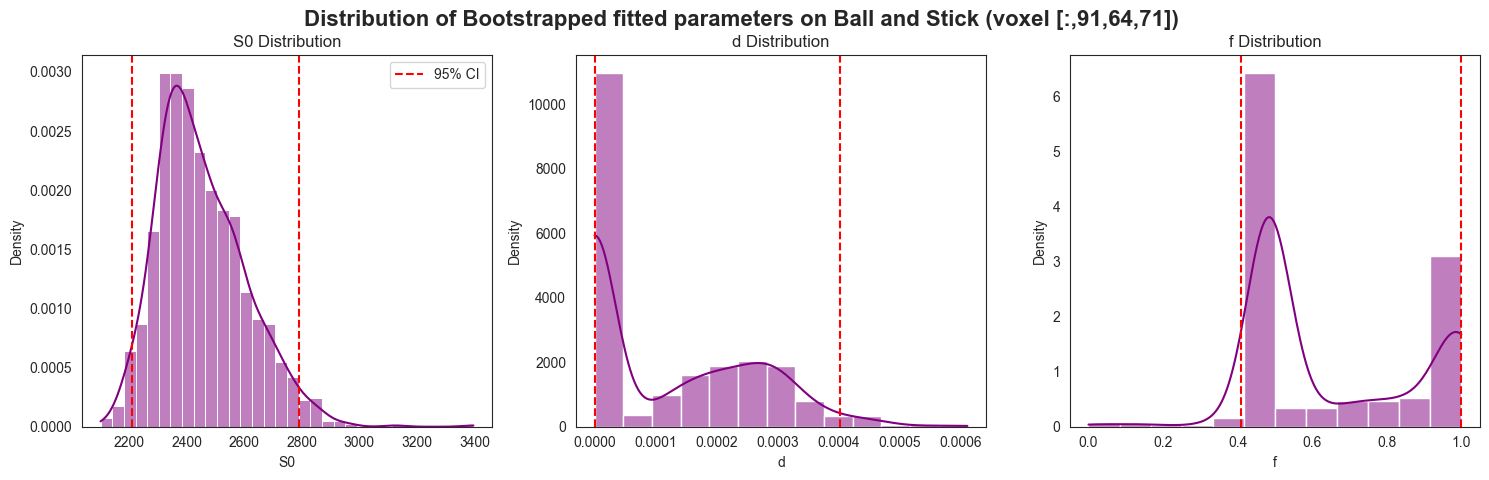

VOXEL: [:,89,72,71]


95% ranges:
S0: [2.131e+03, 2.719e+03]
d: [1.114e-17, 4.149e-04]
f: [4.613e-01, 1.000e+00]

2-sigma ranges (95% confidence intervals):
S0: [2.131e+03, 2.719e+03]
d: [1.114e-17, 4.149e-04]
f: [4.613e-01, 1.000e+00]


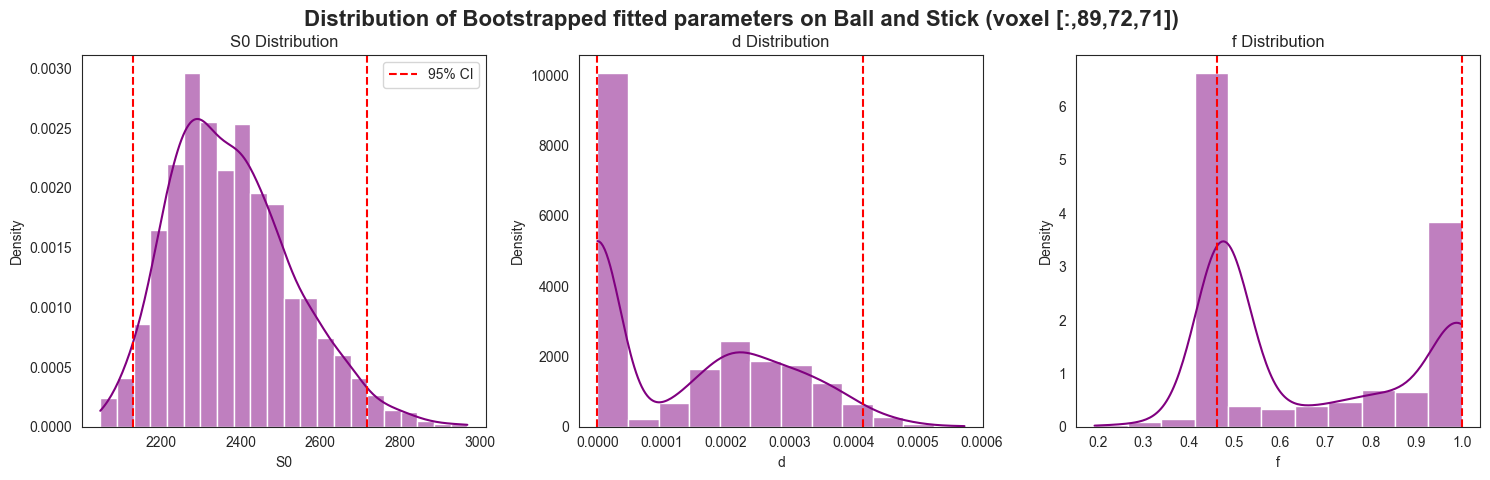

VOXEL: [:,54,51,52]


95% ranges:
S0: [2.699e+03, 3.318e+03]
d: [1.202e-17, 3.468e-04]
f: [4.337e-01, 1.000e+00]

2-sigma ranges (95% confidence intervals):
S0: [2.699e+03, 3.318e+03]
d: [1.202e-17, 3.468e-04]
f: [4.337e-01, 1.000e+00]


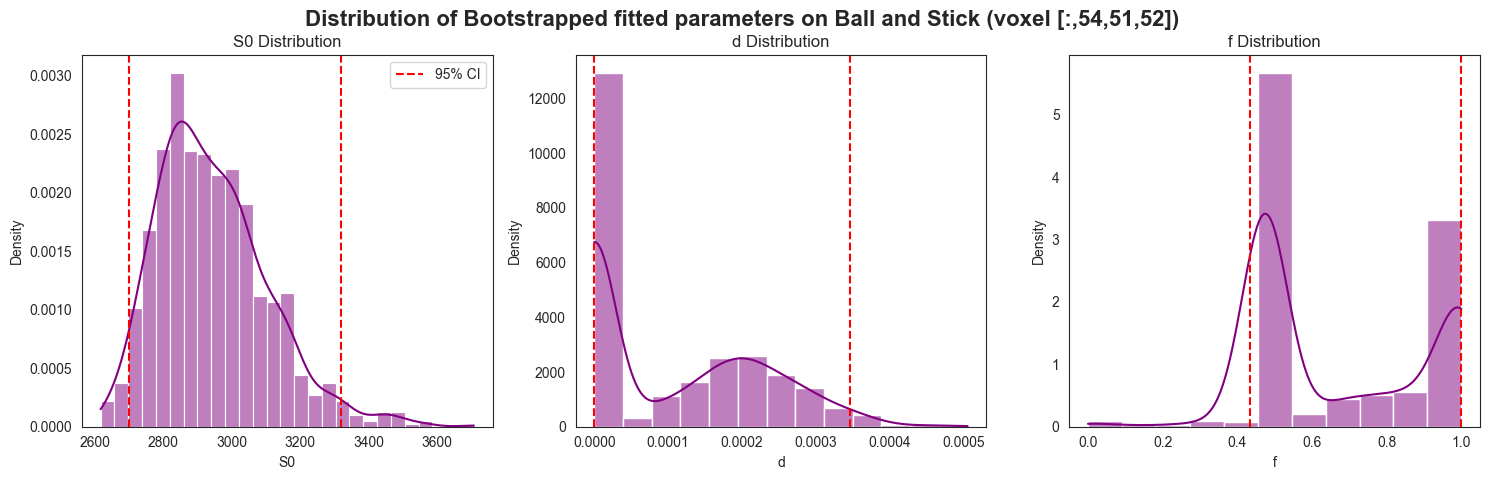

In [ ]:
"""Try some other voxels:"""

voxel_indices = [
    (91, 64, 71), 
    (89, 72, 71),
    (54, 51, 52),
]
# selected_voxels = {
#     "Deep White Matter": (92, 65, 72),
#     "Cortical Gray Matter": (54, 51, 52),
#     "Corpus Callosum": (89, 70, 71),
# }



for voxel_index in voxel_indices:
    n_bootstraps = 1000
    i, j, k = voxel_index  # Get indices for first voxel
    voxel = dwis[:,i,j,k]
    bootstrap_params, two_sigma, ninety_five = bootstrap_ballstick(voxel, bvals, qhat, n_bootstraps)
    
    print(f'VOXEL: [:,{i},{j},{k}]\n')

    # Print results
    param_names = ['S0', 'd', 'f']
    print("\n95% ranges:")
    for i, name in enumerate(param_names):
        print(f"{name}: [{ninety_five[0,i]:.3e}, {ninety_five[1,i]:.3e}]")

    print("\n2-sigma ranges (95% confidence intervals):")
    for i, name in enumerate(param_names):
        print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")

    # Visualize distributions using seaborn
    fig = plt.figure(figsize=(15, 5))
    for i, name in enumerate(param_names):
        plt.subplot(1, 3, i+1)
        sns.histplot(data=bootstrap_params[:,i], stat='density', kde=True, color="purple")
        plt.axvline(two_sigma[0,i], color='r', linestyle='--', label='95% CI')
        plt.axvline(two_sigma[1,i], color='r', linestyle='--')
        plt.title(f'{name} Distribution')
        plt.xlabel(name)
        if i == 0:
            plt.legend()

        
    i, j, k = voxel_index

    fig.suptitle(f'Distribution of Bootstrapped fitted parameters on Ball and Stick (voxel [:,{i},{j},{k}]) ', 
                fontsize=16, 
                fontweight='bold',
                y=0.95)
    plt.tight_layout()
    plt.show()    
    



$\Large{Q1.2.2}$ MCMC

MCMC acceptance rate: 0.62


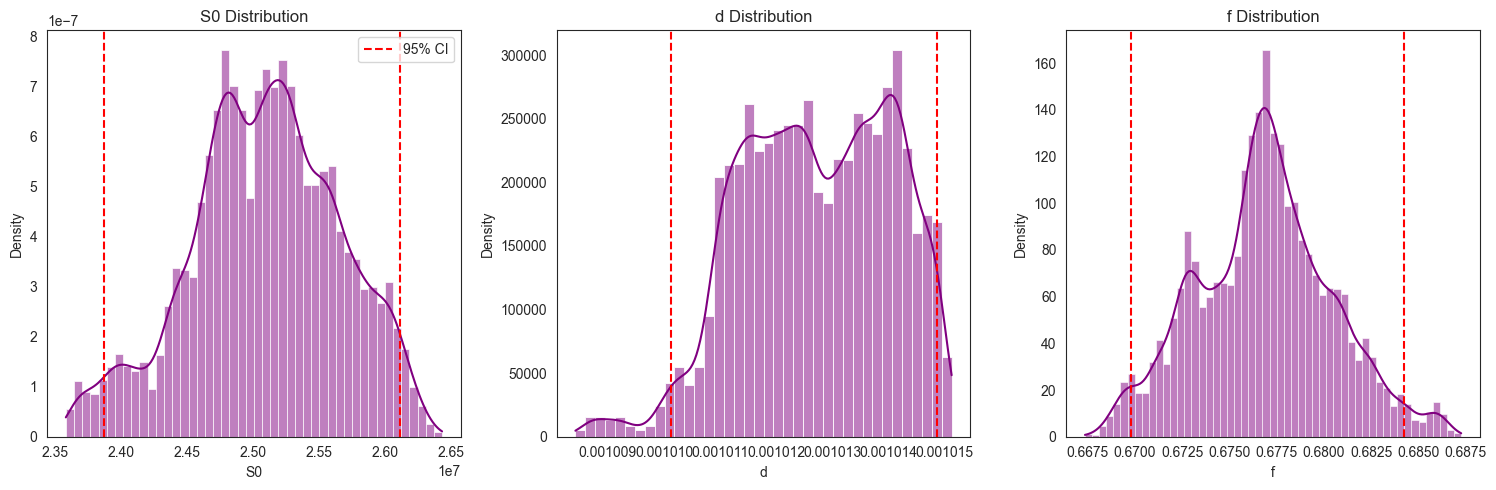


MCMC Parameter Estimates (95% ranges):
S0: [2.387e+07, 2.612e+07]
d: [1.010e-03, 1.015e-03]
f: [6.698e-01, 6.842e-01]

MCMC Parameter Estimates (2-sigma ranges):
S0: [2.387e+07, 2.612e+07]
d: [1.010e-03, 1.015e-03]
f: [6.698e-01, 6.842e-01]


In [ ]:

def log_likelihood(params, voxel, bvals, qhat, noise_std=200):
    try:
        # Generate model predictions
        S0, d, f, theta, phi = params
        
        # Compute fiber direction
        fibdir = np.array([
            np.cos(phi) * np.sin(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(theta)
        ])
        
        # Compute dot product with gradient directions
        fibdotgrad = np.sum(qhat * np.tile(fibdir, (len(bvals), 1)), axis=1)
        
        # Generate predictions
        S = S0 * (f * np.exp(-bvals * d * (fibdotgrad**2)) + 
                  (1-f) * np.exp(-bvals * d))
        
        # Return log likelihood
        return -np.sum((voxel - S)**2) / (2 * noise_std**2)
    
    except:
        return -np.inf

def log_prior(params):
    """
    Calculate log prior probability - uniform within constraints
    
    Args:
        params: Model parameters [S0, d, f, theta, phi]
    """
    S0, d, f, theta, phi = params
    
    # Check constraints
    if (S0 <= 0 or        # S0 must be positive
        d <= 0 or         # diffusivity must be positive
        f < 0 or f > 1 or # volume fraction between 0 and 1
        theta < 0 or theta > np.pi or  # theta between 0 and pi
        phi < -np.pi or phi > np.pi):  # phi between -pi and pi
        return -np.inf
    
    return 0  # Uniform prior within constraints

def log_posterior(params, voxel, bvals, qhat):
    """Calculate log posterior probability"""
    log_pri = log_prior(params)
    if log_pri == -np.inf:
        return -np.inf
    return log_pri + log_likelihood(params, voxel, bvals, qhat)

def metropolis_hastings(voxel, bvals, qhat, n_steps=20000):
    """
    Metropolis-Hastings MCMC sampler for ball-and-stick model parameters S0, d, and f
    
    Args:
        voxel: Observed diffusion signals
        bvals: b-values
        qhat: Gradient directions
        n_steps: Number of MCMC steps
    """
    # Initialize chain with reasonable values (similar to bootstrap)
    current = np.array([
        np.sqrt(3500),      # S0 transform
        np.sqrt(0.001),     # d transform  
        0,                  # f transform (logit space, maps to 0.5)
        0,                  # theta
        0                   # phi
    ])
    
    # Define proposal scales as percentage of parameter values
    base_S0 = 3500
    base_diff = 0.001
    
    proposal_scales = np.array([
        0.1 * base_S0,      # 10% of S0
        0.1 * base_diff,    # 10% of diff
        0.1,                # Fixed scale for f in logit space
        np.pi/8,            # Angular parameters
        np.pi/8
    ])
    
    # Storage for chain (only store S0, d, f)
    chain = np.zeros((n_steps, 3))
    
    # Run MCMC
    accepted = 0
    for i in range(n_steps):
        # Propose new state
        proposal = current + np.random.normal(0, 1, 5) * proposal_scales
        
        # Calculate log acceptance ratio
        log_ratio = (log_posterior(proposal, voxel, bvals, qhat) - 
                    log_posterior(current, voxel, bvals, qhat))
        
        # Accept/reject
        if np.log(np.random.random()) < log_ratio:
            current = proposal
            accepted += 1
        
        # Store transformed parameters (only S0, d, f)
        params = transform_parameters(current)
        chain[i] = params[:3]
        
        # Adapt proposal scales during burn-in
        if i < n_steps//2 and i % 100 == 0:
            acceptance_rate = accepted / (i + 1)
            if acceptance_rate < 0.2:
                proposal_scales *= 0.9
            elif acceptance_rate > 0.5:
                proposal_scales *= 1.1
    
    return chain, accepted/n_steps

def analyze_mcmc_results(chain, burnin=5000):
    """
    Analyze MCMC results and compute confidence intervals for S0, d, f
    """
    # Discard burn-in
    samples = chain[burnin:,:]
    
    # Calculate intervals
    two_sigma = np.percentile(samples, [2.5, 97.5], axis=0)
    ranges_95 = np.percentile(samples, [2.5, 97.5], axis=0)
    
    return two_sigma, ranges_95

def plot_mcmc_diagnostics(chain, burnin=5000):
    """
    Plot MCMC diagnostic plots for S0, d, f
    """
    samples = chain[burnin:,:]
    param_names = ['S0', 'd', 'f']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (name, ax) in enumerate(zip(param_names, axes)):
        # Use seaborn for nicer histograms
        sns.histplot(data=samples[:,i], stat='density', kde=True, ax=ax, color="purple")
        
        # Add confidence intervals
        ax.axvline(two_sigma[0,i], color='r', linestyle='--', label='95% CI')
        ax.axvline(two_sigma[1,i], color='r', linestyle='--')
        
        ax.set_title(f'{name} Distribution')
        ax.set_xlabel(name)
        if i == 0:
            ax.legend()
    
    plt.tight_layout()
    return fig

# Run MCMC analysis
chain, acceptance_rate = metropolis_hastings(voxel, bvals, qhat)
print(f"MCMC acceptance rate: {acceptance_rate:.2f}")

# Analyze results
two_sigma, ranges_95 = analyze_mcmc_results(chain)

# Plot diagnostics
plot_mcmc_diagnostics(chain)
plt.show()

# Print results
param_names = ['S0', 'd', 'f']
print("\nMCMC Parameter Estimates (95% ranges):")
for i, name in enumerate(param_names):
    print(f"{name}: [{ranges_95[0,i]:.3e}, {ranges_95[1,i]:.3e}]")

print("\nMCMC Parameter Estimates (2-sigma ranges):")
for i, name in enumerate(param_names):
    print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")

# Q1.3 - Model Selection

$\Large{Q1.3.1} $

In [391]:
"""LOAD DIFFUSION SIGNAL"""
with open('data_p3/isbi2015_data_normalised.txt', 'r') as f:
    # Skip header
    next(f)
    # Read data - we'll use numpy's loadtxt since it's more straightforward than fscanf
    D = np.loadtxt(f)
    
# Select the first of the 6 voxels
meas = D[:, 0]

"""LOAD PROTOCOL"""
with open('data_p3/isbi2015_protocol.txt', 'r') as f:
    # Skip header
    next(f)
    # Read data
    A = np.loadtxt(f).T
    
# Extract protocol parameters
grad_dirs = A[0:3, :]  # First 3 rows
G = A[3, :]           # 4th row
delta = A[4, :]       # 5th row
smalldel = A[5, :]    # 6th row
TE = A[6, :]          # 7th row

# Constants and calculations
GAMMA = 2.675987E8

# Calculate b-values
# Note: in Python, * operator does element-wise multiplication for numpy arrays
bvals = ((GAMMA * smalldel * G)**2) * (delta - smalldel/3)

# Convert bvals units from s/m^2 to s/mm^2
bvals = bvals / 1e6

print(f"Number of measurements: {len(meas)}")
print(f"Shape of gradient directions: {grad_dirs.shape}")
print(f"Range of b-values: {bvals.min():.2f} to {bvals.max():.2f}")

Number of measurements: 3612
Shape of gradient directions: (3, 3612)
Range of b-values: 0.00 to 45849.55


In [392]:
print("meas shape:", meas.shape)
print("bvals shape:", bvals.shape)
print("grad_dirs shape:", grad_dirs.shape)

meas shape: (3612,)
bvals shape: (3612,)
grad_dirs shape: (3, 3612)


In [393]:
"""UTIL method to optimize voxel for various models"""

def optimize_voxel(model_name, objective, get_startx, voxel, bvals, grad_dirs, num_restarts=1):
    """
    Optimizes a single voxel and returns its parameters, residual norm, and percentage minima.
    """

    best_RESNORM = np.inf
    best_parameters = None
    RESNORM_list = []

    for _ in range(num_restarts):
        startx = get_startx()
        result = minimize(objective, startx, args=(voxel, bvals, grad_dirs),
                        method='Nelder-Mead',
                        )

        RESNORM_list.append(result.fun)

        if result.fun < best_RESNORM:
            best_RESNORM = result.fun
            best_parameters = result.x

    global_minima = np.min(RESNORM_list)
    count_minima = np.count_nonzero(np.isclose(RESNORM_list, global_minima))
    
    return best_parameters, global_minima, count_minima / num_restarts

$\text{\Large{Ball and Stick}}$

$\Large{Q1.3.2} $

In [416]:
def ball_stick(x, bvals, grad_dirs):
    """
    Ball and stick model
    
    Args:
        x: parameters [S0, diff, f, theta, phi]
        bvals: b-values
        grad_dirs: gradient directions (3 x n_measurements)
    """
    # Extract and transform parameters
    S0 = x[0]**2  # Ensure S0 > 0
    diff = x[1]**2  # Ensure diff > 0
    f = 1/(1 + np.exp(-x[2]))  # Maps f to [0,1]
    theta = x[3]  # No transform needed for angles
    phi = x[4]
        
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1)
    # Shape: (3, 1)
    """Reshape fibdir so we can compute matmul"""
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)
    # Calculate signal
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + 
              (1-f) * np.exp(-bvals * diff))
    
    return S

def BallStickSSD_constrained(x, voxel, bvals, grad_dirs):
    S = ball_stick(x, bvals, grad_dirs)
    return np.sum((voxel - S) ** 2)


In [417]:
def get_startx_ball_stick():
    startx = np.array([
        np.sqrt(np.random.uniform(0, 1)),  # Random S0
        np.sqrt(np.random.uniform(0.0001, 0.002)),  # Random diff
        np.random.uniform(-2, 2),  # f
        np.random.uniform(-2, 2),  # theta
        np.random.uniform(-2, 2)   # phi
    ])
    return startx

model_name = "Ball and Stick Constrained"
best_params, best_RESNORM_ball_stick, count_minima = optimize_voxel(model_name, BallStickSSD_constrained, get_startx_ball_stick, meas, bvals, grad_dirs, num_restarts=100)

S_predicted = ball_stick(best_params, bvals, grad_dirs)

print(f"Fitted parameters for: {model_name}:")
print(f"Frequency of Global Minumum: {count_minima}")
print(f"S0: {best_params[0]:.4e}")
print(f"diff: {best_params[1]:.4e}")
print(f"f: {best_params[2]:.4e}")
print(f"theta: {best_params[3]:.4e}")
print(f"phi: {best_params[4]:.4e}")
print(f"\nRESNORM: {best_RESNORM_ball_stick:.4e}")

plot_model_fit(meas, S_predicted, "Ball and Stick Prediction ISBI", yaxis_title="Normalized Signal")


Fitted parameters for: Ball and Stick Constrained:
Frequency of Global Minumum: 0.94
S0: 1.0049e+00
diff: 3.7842e-02
f: 3.0195e-01
theta: 1.5447e+00
phi: 3.0587e+00

RESNORM: 1.5106e+01


$\text{\Large{Diffusion Tensor}}$

In [409]:
def diffusion_tensor(x, bvals, grad_dirs):
    """
    Compute diffusion tensor model predictions
    
    Args:
        x: transformed parameters [S0, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz]
        bvals: b-values
        grad_dirs: gradient directions (3 x n_measurements)
    """
    # Transform parameters to ensure physical constraints
    S0 = x[0]**2  # Ensure positive
    
    # Construct diffusion tensor
    D = np.array([[x[1], x[2], x[3]],
                  [x[2], x[4], x[5]],
                  [x[3], x[5], x[6]]])
    
    # Calculate predicted signals
    signals = np.zeros(len(bvals))
    for i in range(len(bvals)):
        g = grad_dirs[:,i]
        signals[i] = S0 * np.exp(-bvals[i] * g.T @ D @ g)
    
    return signals

def diffusion_tensor_SSD(x, voxel, bvals, grad_dirs):
    """Compute sum of squared differences"""
    S = diffusion_tensor(x, bvals, grad_dirs)
    return np.sum((voxel - S) ** 2)

def fit_diffusion_tensor_minimize(meas, bvals, grad_dirs):
    """
    Fit diffusion tensor model using minimize
    """
    # Initial parameter guess
    x0 = np.array([
        1.0,     # sqrt(S0) (normalized data)
        2e-3,    # Dxx
        0,       # Dxy
        0,       # Dxz
        2e-3,    # Dyy
        0,       # Dyz
        2e-3     # Dzz
    ])
    
    result = minimize(
        diffusion_tensor_SSD,
        x0,
        args=(meas, bvals, grad_dirs),
        method='Nelder-Mead',
    )
    
    return result

def diffusion_tensor_predict(x, bvals, grad_dirs):
    """Generate predictions from diffusion tensor model"""
    S0 = x[0]**2  # Ensure positive
    
    D = np.array([[x[1], x[2], x[3]],
                  [x[2], x[4], x[5]],
                  [x[3], x[5], x[6]]])
    
    signals = np.zeros(len(bvals))
    for i in range(len(bvals)):
        g = grad_dirs[:,i]
        signals[i] = S0 * np.exp(-bvals[i] * g.T @ D @ g)
    
    return signals

diffusion_tensor_result = fit_diffusion_tensor_minimize(meas, bvals, grad_dirs)
S_predicted = diffusion_tensor_predict(diffusion_tensor_result.x, bvals, grad_dirs)
best_params = diffusion_tensor_result.x

model_name = "Diffusion Tensor"
print(f"Fitted parameters for: {model_name}:")
print(f"S0: {best_params[0]:.4e}")
print(f"D0: {best_params[1]:.4e}")
print(f"D1: {best_params[2]:.4e}")
print(f"D2: {best_params[3]:.4e}")
print(f"D3 ...: {best_params[4]:.4e}")
print(f"\nRESNORM: {diffusion_tensor_result.fun:.4e}")

plot_model_fit(meas, S_predicted, "Diffusion Tensor Prediction ISBI",yaxis_title="Normalized Signal")


Fitted parameters for: Diffusion Tensor:
S0: 9.8175e-01
D0: 1.6653e-03
D1: -1.5645e-04
D2: -3.1665e-05
D3 ...: 1.5390e-04

RESNORM: 1.8191e+01


$\text{\large{Zeppelin \& Stick Model}}$

In [418]:
def zeppelin_stick(x, bvals, grad_dirs):
    S0 = x[0]**2
    diff = x[0]**2 * x[1]**2
    f = np.exp(-x[2]**2)
    lambda1 = diff
    lambda2 = x[3]**2
    theta = x[4]
    phi = x[5]
    
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1) 
    
    # Calculate dot product with all gradient directions
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)  # Result shape (n_measurements,)
    stick_signal = f * np.exp(-bvals * diff * (fibdotgrad**2))
    zeppelin_signal = (1-f) * np.exp(-bvals * (lambda2 + (lambda1 - lambda2) * fibdotgrad**2))
    
    # Total signal
    S = S0 * (stick_signal + zeppelin_signal)
    
    # Return sum of squared differences
    return S


def zeppelin_stick_SSD(x, voxel, bvals, grad_dirs):
    S = zeppelin_stick(x, bvals, grad_dirs)
    return np.sum((voxel - S) ** 2)


In [423]:
def get_startx_zeppelin_stick():
    startx = np.array([
        np.sqrt(np.random.uniform(0, 1)),
        np.sqrt(np.random.uniform(0.0001, 0.002)),   # diff transform (small positive value)
        np.random.uniform(-2, 2),  # f
        np.sqrt(np.random.normal(0.0005, 0.0001)),  # lambda2 transform (smaller than diff)
        np.random.uniform(-2, 2),  # theta
        np.random.uniform(-2, 2)   # phi
    ])
    
    return startx

model_name = "Zeppelin Stick"
best_params, best_RESNORM_zeppelin_stick, count_minima = optimize_voxel(model_name, zeppelin_stick_SSD, get_startx_zeppelin_stick, meas, bvals, grad_dirs=grad_dirs, num_restarts=100)

# Generate predictions for plotting
S_predicted = zeppelin_stick(best_params, bvals, grad_dirs)

print(f"Fitted parameters for: {model_name}:")
print(f"Frequency of Global Minumum: {count_minima}")
print(f"S0: {best_params[0]:.4e}")
print(f"diff: {best_params[1]:.4e}")
print(f"f: {best_params[2]:.4e}")
print(f"theta: {best_params[3]:.4e}")
print(f"phi: {best_params[4]:.4e}")
print(f"\nRESNORM: {best_RESNORM_zeppelin_stick:.4e}")

plot_model_fit(meas, S_predicted, "Zeppelin Stick Prediction ISBI", yaxis_title="Normalized Signal")


Fitted parameters for: Zeppelin Stick:
Frequency of Global Minumum: 0.37
S0: 9.9148e-01
diff: 4.0135e-02
f: -9.1194e-01
theta: 2.1622e-02
phi: -1.5438e+00

RESNORM: 1.0817e+01


$\text{\large{Zeppelin \& Stick w/ Tortuosity Model}}$

In [ ]:
"""Adapt for various models"""

def zeppelin_stick_tortuosity(x, bvals, grad_dirs):
    # Extract and transform parameters
    S0 = x[0]**2
    diff = x[0]**2 * x[1]**2
    f = np.exp(-x[2]**2)
    # Tortuosity constraint: λ2 = (1-f)λ1
    lambda1 = diff
    lambda2 = (1-f) * lambda1    
    theta = x[3]
    phi = x[4]
    
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1) 
    
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)  # Result shape (n_measurements,)
    
    # Stick component
    stick_signal = f * np.exp(-bvals * diff * (fibdotgrad**2))
    
    # Zeppelin component
    zeppelin_signal = (1-f) * np.exp(-bvals * (lambda2 + (lambda1 - lambda2) * fibdotgrad**2))
    
    S = S0 * (stick_signal + zeppelin_signal)
    return S

def zeppelin_stick_tortuosity_SSD(x, voxel, bvals, grad_dirs):
    """Calculate sum of squared differences"""
    S = zeppelin_stick_tortuosity(x, bvals, grad_dirs)
    return np.sum((voxel - S) ** 2)

In [ ]:
def get_startx_zeppelin_tortuosity():
    """Generate starting point for zeppelin-stick with tortuosity"""
    startx = np.array([
        np.sqrt(np.random.uniform(0, 1)),     # S0
        np.sqrt(np.random.uniform(0.0001, 0.002)),  # diff (lambda1)
        np.random.uniform(-2, 2),                    # f
        np.random.uniform(-2, 2),                    # theta
        np.random.uniform(-2, 2)                     # phi
    ])
    return startx

model_name = "Zeppelin Stick with Tortuosity"
best_params, best_RESNORM_zeppelin_tortuosity, count_minima = optimize_voxel(
    model_name, 
    zeppelin_stick_tortuosity_SSD, 
    get_startx_zeppelin_tortuosity, 
    meas, 
    bvals, 
    grad_dirs=grad_dirs, 
    num_restarts=100
)

S_predicted = zeppelin_stick_tortuosity(best_params, bvals, grad_dirs)

lambda2 = (1 - best_params[2]) * best_params[1]

print(f"Fitted parameters for: {model_name}:")
print(f"Frequency of Global Minumum: {count_minima}")
print(f"S0: {best_params[0]:.4e}")
print(f"diff: {best_params[1]:.4e}")
print(f"f: {best_params[2]:.4e}")
print(f"lambda2: {lambda2:.4e}")
print(f"theta: {best_params[3]:.4e}")
print(f"phi: {best_params[4]:.4e}")
print(f"\nRESNORM: {best_RESNORM_zeppelin_tortuosity:.4e}")

# Plot results
plot_model_fit(meas, S_predicted, "Zeppelin Stick with Tortuosity Prediction ISBI", yaxis_title="Normalized Signal")

Fitted parameters for: Zeppelin Stick with Tortuosity:
Frequency of Global Minumum: 0.77
S0: 9.9566e-01
diff: 3.9288e-02
f: 8.1199e-01
lambda2: 7.3866e-03
theta: -1.5442e+00
phi: -8.7057e-02

RESNORM: 1.1605e+01


$\Large{Q1.3.3} $

In [ ]:
"""Rank models with AIC and BIC"""
import pandas as pd
from dataclasses import dataclass

@dataclass
class ModelInfo:
    name: str
    n_params: int 
    residual_norm: float 
    n_samples: int 
    
def calculate_criteria(model_info: ModelInfo):
    n = model_info.n_samples
    RESNORM = model_info.residual_norm
    k = model_info.n_params
    
    # Calculate AIC
    AIC = n * np.log(RESNORM/n) + 2*k
    
    # Calculate BIC
    BIC = n * np.log(RESNORM/n) + k * np.log(n)
    
    return {
        'AIC': AIC,
        'BIC': BIC,
        'RESNORM': RESNORM,
        'n_params': k
    }

def compare_models(models) -> pd.DataFrame:
    """Compare multiple models using AIC and BIC"""
    results = []
    
    # Calculate criteria for each model
    for model in models:
        criteria = calculate_criteria(model)
        criteria['name'] = model.name
        results.append(criteria)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Calculate delta AIC and BIC (difference from minimum)
    df['delta_AIC'] = df['AIC'] - df['AIC'].min()
    df['delta_BIC'] = df['BIC'] - df['BIC'].min()
    
    # Calculate Akaike weights
    min_aic = df['AIC'].min()
    df['rel_likelihood'] = np.exp(-0.5 * (df['AIC'] - min_aic))
    sum_likelihood = df['rel_likelihood'].sum()
    df['akaike_weight'] = df['rel_likelihood'] / sum_likelihood
    
    # Sort by AIC
    df = df.sort_values('AIC')
    
    return df[['name', 'n_params', 'RESNORM', 'AIC', 'delta_AIC', 
              'akaike_weight', 'BIC', 'delta_BIC']]    


dt_info = ModelInfo(
    name="Diffusion Tensor",
    n_params=2,  # S0, diff
    residual_norm=diffusion_tensor_result.fun,
    n_samples=len(meas)
)


ball_stick_info = ModelInfo(
    name="Ball-Stick",
    n_params=5,  # S0, diff, f, theta, phi
    residual_norm=best_RESNORM_ball_stick,
    n_samples=len(meas)
)

zeppelin_stick_info = ModelInfo(
    name="Zeppelin-Stick",
    n_params=6,  # S0, diff, f, lambda2, theta, phi
    residual_norm=best_RESNORM_zeppelin_stick,
    n_samples=len(meas)
)

zeppelin_tort_info = ModelInfo(
    name="Zeppelin-Stick-Tortuosity",
    n_params=5,  # S0, diff, f, theta, phi (lambda2 determined by tortuosity)
    residual_norm=best_RESNORM_zeppelin_tortuosity,
    n_samples=len(meas)
)

# Compare models
comparison = compare_models([
    dt_info,
    ball_stick_info,
    zeppelin_stick_info,
    zeppelin_tort_info
])

print("\nModel Comparison:")
print(comparison.round(2).to_string())

# Print interpretation
best_model = comparison.iloc[0]
print(f"\nBest model according to AIC: {best_model['name']}")
print(f"This model has {best_model['akaike_weight']*100:.1f}% probability of being the best model")
print("\nInterpretation of delta AIC:")


Model Comparison:
                        name  n_params  RESNORM       AIC  delta_AIC  akaike_weight       BIC  delta_BIC
2             Zeppelin-Stick         6    10.82 -20977.07       0.00            1.0 -20939.92       0.00
3  Zeppelin-Stick-Tortuosity         5    11.61 -20724.91     252.16            0.0 -20693.95     245.97
1                 Ball-Stick         5    15.11 -19772.65    1204.42            0.0 -19741.69    1198.23
0           Diffusion Tensor         2    18.19 -19107.40    1869.67            0.0 -19095.02    1844.90

Best model according to AIC: Zeppelin-Stick
This model has 100.0% probability of being the best model

Interpretation of delta AIC:
0-2: Substantial support for model
4-7: Considerably less support
>10: Essentially no support


$\text{From our model comparison we can confirm that Zepplin-Stick-Tortuosity is the best model to use. Given that it has the lowest RSS, average number of parameters, and as such the highest Akaike weight. } \\ \text{This makes sense, it has one less parameter than Zeppelin-Stick but has a ~30\% decrease in the error on its predictions. So, it has the best balance of complexity and performance.}$

$\text{\Large{ Q1.3.4 Extend Range of Models (Further Question)}}$